# Simulation of different circuit perparation of GKP codes

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import optimization
import evaluation
import pandas as pd
import strawberryfields as sf

/Users/etiennestock/Documents/packages/strawberryfields/strawberryfields/apps/data/sample.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# general stuff
state_dict = {(0, 0): '0', (np.pi, 0): '1', (np.pi/2, 0): '+'} # dictionary to save the state properly

def Vtanhgate(s): return sf.ops.Vgate(np.tanh(s)) 
def Kdl2c2gate(kappa): return sf.ops.Kdlcgate(kappa, 2, 2)
def Kdl6c2gate(kappa): return sf.ops.Kdlcgate(kappa, 6, 2)
def Kdl10c2gate(kappa): return sf.ops.Kdlcgate(kappa, 10, 2)

In [5]:
# hyperparameters of the current run
cutoff     = 30
delta      = 0.25 
epsilon    = delta**2 
num_trials = 1 
n_jobs     = 2 
state      = [0, 0] 
num_blocks = [15, 15, 15, 15, 15, 15] 
circuit    = 'XRVtanhS'
gates      = np.array([sf.ops.Xgate, sf.ops.Rgate, Vtanhgate, sf.ops.Sgate])
rev_gates  = np.array([sf.ops.Sgate, Vtanhgate, sf.ops.Rgate, sf.ops.Xgate])

In [10]:
# arrays to store data for plots and error analysis 
max_params = max(num_blocks)
opt        = np.empty(len(num_blocks), dtype=optimization.Optimization)
Fids       = np.empty((len(num_blocks), num_trials), dtype=np.float32)
bestFids   = np.empty(len(num_blocks), dtype=np.float32) 

# parallel optimization
params = 0.1*np.random.rand(num_blocks[0]*len(gates))
for i in range(len(num_blocks)):
    opt[i] = optimization.Optimization(gates=gates, circuit=circuit, cutoff=cutoff, delta=delta, epsilon=epsilon, num_blocks=num_blocks[i], num_trials=num_trials, state=state)
    Fids[i], _ = opt[i].parallel_optimize_circuit(params=params)   
    params = opt[i].get_bestSol()
    bestFids[i] = opt[i].get_bestFid()
    print(f'{i}. optimization done with a fidelity of {bestFids[i]}!')

0. optimization done with a fidelity of 0.8390948176383972!
1. optimization done with a fidelity of 0.8390948176383972!
2. optimization done with a fidelity of 0.8390948176383972!
3. optimization done with a fidelity of 0.8390948176383972!
4. optimization done with a fidelity of 0.8390948176383972!
5. optimization done with a fidelity of 0.8390948176383972!


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [29]:
# store data in pandas data frame
results = pd.DataFrame()
results['methods'] = np.repeat(circuit, len(num_blocks))
for i in range(num_trials): 
    results[f'{i+1}: ' + r'$\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$'] = Fids[:,i]
results[r'$\max_i\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$'] = bestFids

results

,methods,1: $\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$,$\max_i\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$
0,XRVtanhS,0.839095,0.839095
1,XRVtanhS,0.839095,0.839095
2,XRVtanhS,0.839095,0.839095
3,XRVtanhS,0.839095,0.839095
4,XRVtanhS,0.839095,0.839095
5,XRVtanhS,0.839095,0.839095


In [8]:
# save data in folder data
for i in range(len(circuits)): 
    file_name = f"data_{state_dict[tuple(state)]}_{circuits[i]}_{cutoff}_{str(delta).replace('.', '')}_{num_blocks[i]}"
    opt[i].save(file_name)

In [31]:
# prepare the target state in Fock basis, so that we can compare with our generated state
target_GKP = evaluation.prepare_GKP(epsilon=epsilon, cutoff=cutoff, state=state).ket()

# compute norm of the generated states and the fidelity between target state and generated state
generated_GKP = np.empty((len(num_blocks), cutoff), dtype=np.complex64)
normgen       = np.empty(len(num_blocks), dtype=np.float32)
fid           = np.empty(len(num_blocks), dtype=np.float32)

for i in range(len(num_blocks)):    
    generated_GKP[i] = evaluation.prepare_state(rev_gates, -np.flip(opt[i].get_bestSol()), cutoff).ket()
    normgen[i]       = np.dot(generated_GKP[i].conj(), generated_GKP[i])
    fid[i]           = np.abs(np.dot(generated_GKP[i].conj(), target_GKP))**2

# add results
results[r'$|\langle\Psi_g|\Psi_g\rangle|^2$'] = normgen
results[r'$|\langle\Psi_g|\Psi_t\rangle|^2$'] = fid

/var/folders/6q/7zspg0xj68g0zq09v2tt_hyh0000gn/T/ipykernel_50833/3717506311.py:11: ComplexWarning: Casting complex values to real discards the imaginary part


In [32]:
# calculate the norm of the target state for consistency
normtarg = np.abs(np.dot(target_GKP.conj(), target_GKP))
pd.DataFrame([normtarg], [r'$\left|\left<\Psi_t |\Psi_t \right>\right|^2$'])

,0
$\left|\left<\Psi_t |\Psi_t \right>\right|^2$,1.0


In [33]:
# show results of this optimization round
results

,methods,1: $\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$,$\max_i\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$,$|\langle\Psi_g|\Psi_g\rangle|^2$,$|\langle\Psi_g|\Psi_t\rangle|^2$
0,XRVtanhS,0.839095,0.839095,0.931666,0.839095
1,XRVtanhS,0.839095,0.839095,0.931663,0.839095
2,XRVtanhS,0.839095,0.839095,0.931663,0.839095
3,XRVtanhS,0.839095,0.839095,0.931663,0.839095
4,XRVtanhS,0.839095,0.839095,0.931663,0.839095
5,XRVtanhS,0.839095,0.839095,0.931663,0.839095


<>:17: SyntaxWarning: invalid escape sequence '\P'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\P'
<>:19: SyntaxWarning: invalid escape sequence '\s'
/var/folders/6q/7zspg0xj68g0zq09v2tt_hyh0000gn/T/ipykernel_50833/4182563334.py:17: SyntaxWarning: invalid escape sequence '\P'
/var/folders/6q/7zspg0xj68g0zq09v2tt_hyh0000gn/T/ipykernel_50833/4182563334.py:19: SyntaxWarning: invalid escape sequence '\s'


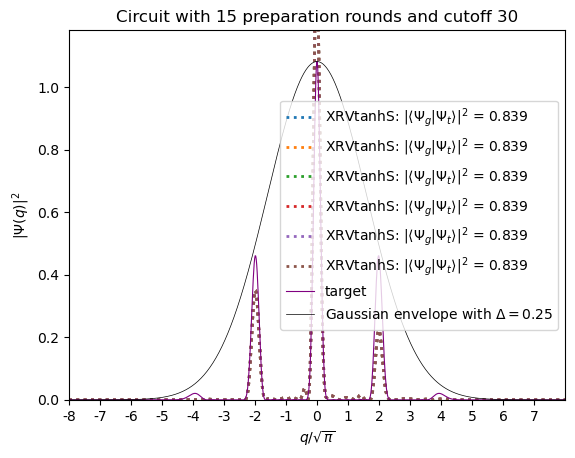

In [38]:
# Plot probability distribution of generated and target GKP states
qnum    = 8
qlim    = qnum*np.sqrt(np.pi)
qvalues = np.linspace(-qlim,qlim, 1000)

targetGKPwf = evaluation.wavefunction(q=qvalues, ket=target_GKP)
gauss       = lambda x: np.max(np.abs(targetGKPwf*targetGKPwf.conj())) * np.exp(-x**2*(delta)**2)

genGKPwf    = np.empty((len(num_blocks), 1000), dtype=np.complex64)
for i in range(len(num_blocks)):
    genGKPwf[i] = evaluation.wavefunction(q=qvalues, ket=generated_GKP[i])
    plt.plot(qvalues, np.abs(genGKPwf[i]*genGKPwf[i].conj()), label=f'{circuit}: '+r'$|\langle\Psi_g|\Psi_t\rangle|^2$'+f' = {fid[i]:.3f}', linestyle='dotted', linewidth=2)

plt.plot(qvalues, np.abs(targetGKPwf*targetGKPwf.conj()), label='target', color='purple', linewidth=0.8)
plt.plot(qvalues, gauss(qvalues), label=r'Gaussian envelope with $\Delta =$'+f'{delta}', color='black', linewidth=0.5)

plt.ylabel("$|\Psi(q)|^2$")
plt.xticks(np.sqrt(np.pi)*np.arange(-qnum, qnum), np.arange(-qnum, qnum))
plt.xlabel("$q/\sqrt{\pi}$")
plt.xlim(np.min(qvalues), np.max(qvalues))
plt.ylim(0, np.max(np.abs(targetGKPwf*targetGKPwf.conj()))+0.1)
plt.title(f'Circuit with {np.max(num_blocks)} preparation rounds and cutoff {cutoff}')
plt.legend()

# plt.savefig(f'plots/plot_{cutoff}_{str(delta).replace(".", "")}_{np.max(num_blocks)}_' + '_' + circuit + '.png')
plt.show()

In [40]:
# calculate the Knill-Glancy error
n    = 30 
size = 30 

results[r'$P_{\text{error}}$'] = np.empty(len(num_blocks), dtype=np.float32)
for i in range(len(num_blocks)): 
    results.loc[i, r'$P_{\text{error}}$'] = evaluation.error_gancy_knill(generated_GKP[i], n, size)

/var/folders/6q/7zspg0xj68g0zq09v2tt_hyh0000gn/T/ipykernel_50833/5084941.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3856190942842024' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.


In [41]:
results

,methods,1: $\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$,$\max_i\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$,$|\langle\Psi_g|\Psi_g\rangle|^2$,$|\langle\Psi_g|\Psi_t\rangle|^2$,$P_{\text{error}}$
0,XRVtanhS,0.839095,0.839095,0.931666,0.839095,0.385619
1,XRVtanhS,0.839095,0.839095,0.931663,0.839095,0.385614
2,XRVtanhS,0.839095,0.839095,0.931663,0.839095,0.385614
3,XRVtanhS,0.839095,0.839095,0.931663,0.839095,0.385614
4,XRVtanhS,0.839095,0.839095,0.931663,0.839095,0.385614
5,XRVtanhS,0.839095,0.839095,0.931663,0.839095,0.385614


- reusing the parameters of the previous try results in the same optimum
- local extremum, not globally
- lot of tries to search for th